In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from nb_005 import *

# STL-10

## Basic data aug

In [ ]:
PATH = Path('data/stl10')

data_mean, data_std = map(tensor, ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
data_norm,data_denorm = normalize_funcs(data_mean,data_std)

train_ds = ImageDataset.from_folder(PATH/'train')
valid_ds = ImageDataset.from_folder(PATH/'valid')

torch.Size([3, 96, 96])

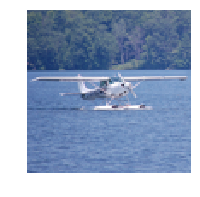

In [ ]:
x=valid_ds[0][0]
x.show()
x.shape

In [ ]:
size=96
tfms = get_transforms(do_flip=True, max_rotate=10, max_lighting=0.2, max_warp=0.15, max_zoom=1.2)
# tfms = get_transforms(do_flip=True, max_rotate=10, max_lighting=0.2)
tds = transform_datasets(train_ds, valid_ds, tfms, size=size)#, padding_mode='zeros')
data = DataBunch.create(*tds, bs=32, num_workers=8, tfms=data_norm)

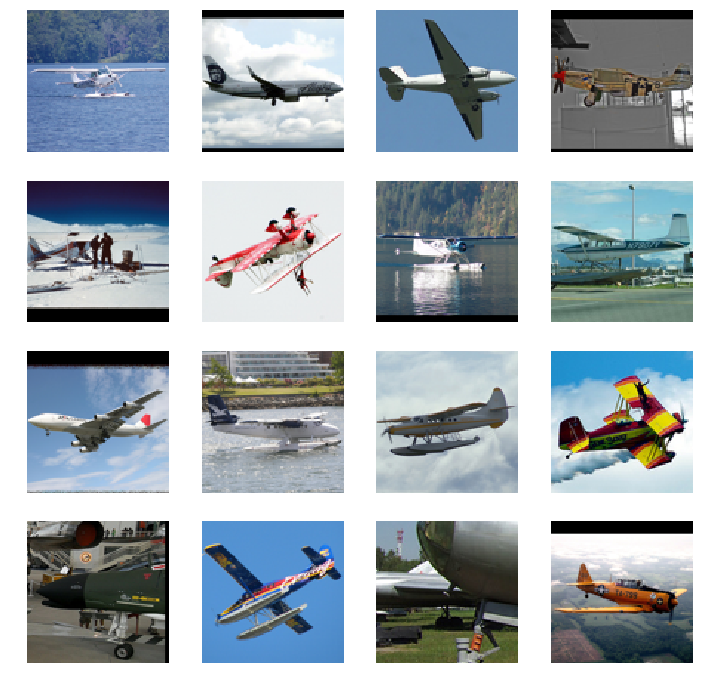

In [ ]:
(x,y) = next(iter(data.valid_dl))

_,axs = plt.subplots(4,4,figsize=(12,12))
for i,ax in enumerate(axs.flatten()): show_image(data_denorm(x[i].cpu()), ax)

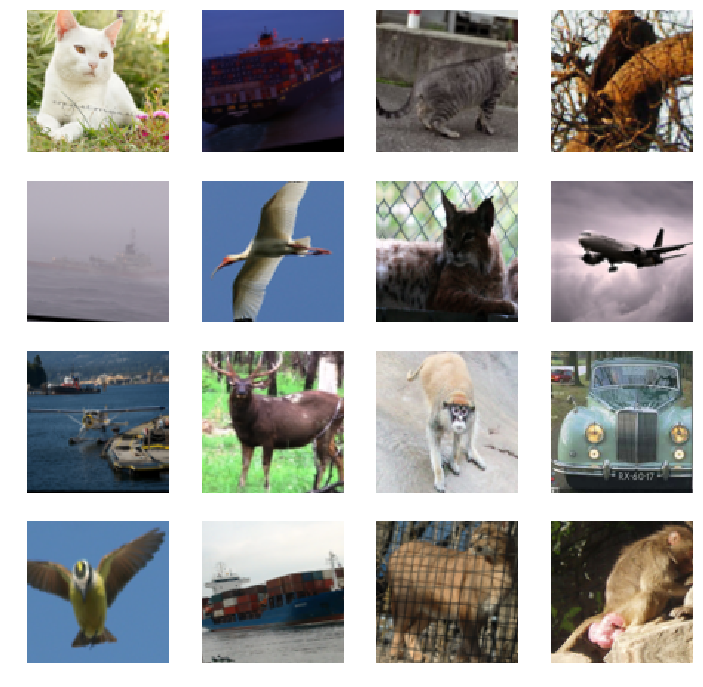

In [ ]:
(x,y) = next(iter(data.train_dl))

_,axs = plt.subplots(4,4,figsize=(12,12))
for i,ax in enumerate(axs.flatten()): show_image(data_denorm(x[i].cpu()), ax)

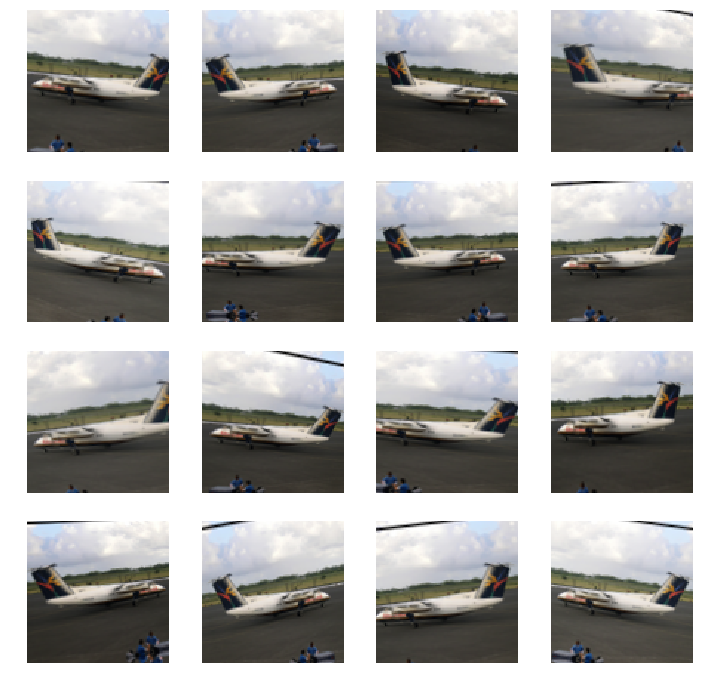

In [ ]:
_,axs = plt.subplots(4,4,figsize=(12,12))
for i,ax in enumerate(axs.flat): tds[0][1][0].show(ax)

## Train

In [ ]:
from torchvision.models import resnet18, resnet34, resnet50
arch = resnet50

In [ ]:
lr = 2e-3

In [ ]:
learn = ConvLearner(data, arch, 2 , wd=1e-1) #, train_bn=False #, callback_fns=[BnFreeze]
#                     , opt_fn=partial(optim.SGD, momentum=0.9))
learn.metrics = [accuracy]
learn.split(lambda m: (m[0][6], m[1]))

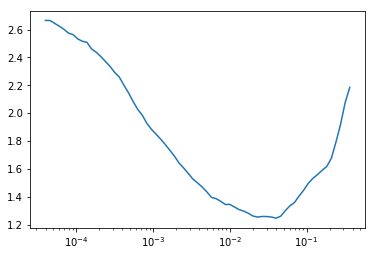

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, slice(lr))

Total time: 01:30
epoch  train loss  valid loss  accuracy
0      0.550218    0.369369    0.872692  (00:14)
1      0.389043    0.287710    0.903462  (00:14)
2      0.354424    0.225025    0.926154  (00:15)
3      0.257456    0.202688    0.930000  (00:15)
4      0.205147    0.180714    0.942308  (00:15)
5      0.176819    0.176531    0.941538  (00:15)



In [ ]:
learn.save('0')

## Gradual unfreezing

In [ ]:
learn.load('0')

In [ ]:
learn.unfreeze()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(6, slice(lr/25,lr))

Total time: 02:01
epoch  train loss  valid loss  accuracy
0      0.230329    0.228656    0.924615  (00:20)
1      0.305863    0.254649    0.916154  (00:19)
2      0.324937    0.338827    0.886154  (00:20)
3      0.276075    0.260066    0.916538  (00:20)
4      0.136763    0.194284    0.940385  (00:20)
5      0.074670    0.176807    0.945769  (00:20)



In [ ]:
learn.save('1')

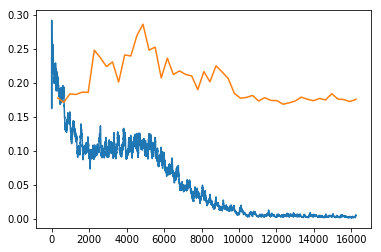

In [ ]:
learn.recorder.plot_losses()

## Fin

In [ ]:
import pandas as pd
csv = pd.read_csv(PATH/'default.csv')
is_valid = csv['2']=='valid'
valid_df,train_df = csv[is_valid],csv[~is_valid]
len(valid_df),len(train_df)

In [ ]:
len(valid_ds)

2600

In [ ]:
train_fns,train_lbls,valid_fns,valid_lbls = map(np.array,
    (train_df['0'],train_df['1'],valid_df['0'],valid_df['1']))

train_fns = [PATH/o for o in train_fns]
valid_fns = [PATH/o for o in valid_fns]

train_ds = ImageDataset(train_fns,train_lbls)
valid_ds = ImageDataset(valid_fns,valid_lbls, classes=train_ds.classes)